# Detección de Fraude con Tarjetas de crédito
# Grupo 3
## Bruno Dueñas, Fernando Mejía, Mateo Córdova

# Importar librerías

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Machine Learning
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import linear_model,preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable
import tensorflow as tf
import graphviz

## Importando la data proveniente del csv y mostrándo el contenido de la data

In [94]:
column_names = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price","repeat_retailer","used_chip","used_pin_number","online_order","fraud"]
dframe=pd.read_csv("data/card_transdata.csv")
dframe

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


## Copia para el modelo en keras

In [95]:
dframeKeras = dframe.copy()

## Copia para el arbol de decisión sklearn

In [96]:
dframeArbol = dframe.copy()

## Encontrar las características que mejor describen los datos

In [97]:
dframe.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


### NOTA: No se realiza la detección de valores atípicos, porque los valores tendrán un efecto en la variable de destino (fraude)

## Revisar valores nulos (de existir)

In [98]:
dframe.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

### Recuentos de valores para variables categóricas (repeat_retailer, used_chip, used_pin_number, online_order y fraude)

In [99]:
for column in dframe.columns[3:9]:
    print(dframe[column].value_counts())
    print()

1.0    881536
0.0    118464
Name: repeat_retailer, dtype: int64

0.0    649601
1.0    350399
Name: used_chip, dtype: int64

0.0    899392
1.0    100608
Name: used_pin_number, dtype: int64

1.0    650552
0.0    349448
Name: online_order, dtype: int64

0.0    912597
1.0     87403
Name: fraud, dtype: int64



## Matriz de correlación entre la data

<AxesSubplot:>

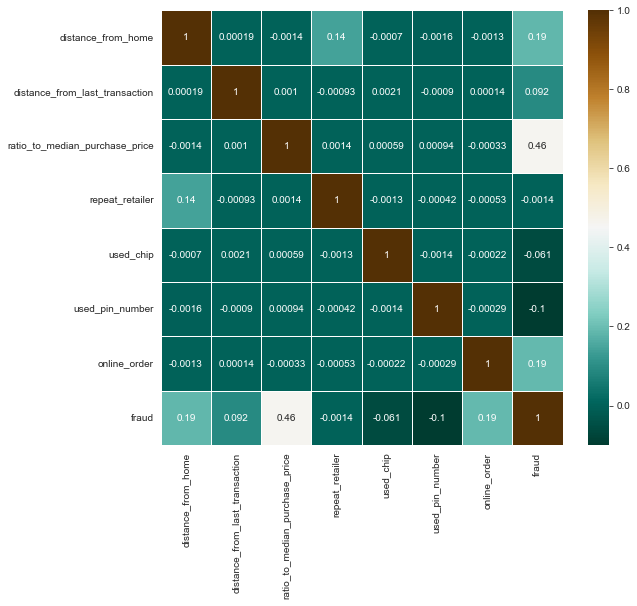

In [100]:
correlation_mat = dframe.corr() 
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(correlation_mat,ax=ax, annot=True, cmap = 'BrBG_r',linewidths=0.5)

<b>Two Feature Analysis - (Fraud, other_categorical_variables) in x axis and number of records in y axis<b>

Text(0, 0.5, 'number of records')

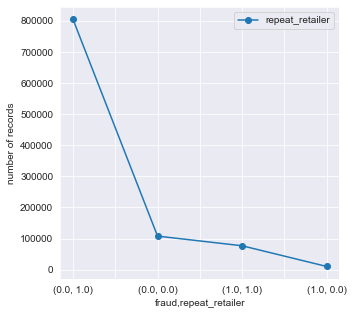

In [101]:
#Fraud - repeat_retailer
fig, ax = plt.subplots(figsize=(5,5))
dframe.groupby('fraud')['repeat_retailer'].value_counts().plot(legend=True,marker='o',ax=ax)
plt.ylabel("number of records")

Text(0, 0.5, 'number of records')

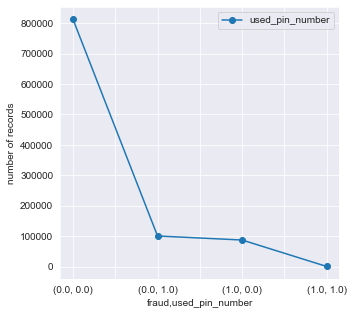

In [102]:
#Fraud - used_pin_number
fig, ax = plt.subplots(figsize=(5,5))
dframe.groupby('fraud')['used_pin_number'].value_counts().plot(legend=True,marker='o',ax=ax)
plt.ylabel("number of records")

Text(0, 0.5, 'number of records')

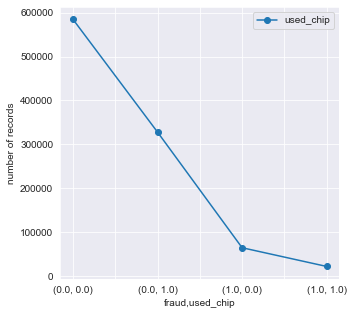

In [103]:
#Fraud - used_chip
fig, ax = plt.subplots(figsize=(5,5))
dframe.groupby('fraud')['used_chip'].value_counts().plot(legend=True,marker='o',ax=ax)
plt.ylabel("number of records")

Text(0, 0.5, 'number of records')

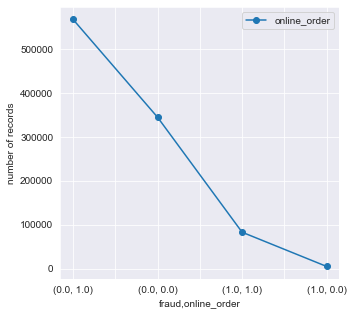

In [104]:
#Fraud - online_order
fig, ax = plt.subplots(figsize=(5,5))
dframe.groupby('fraud')['online_order'].value_counts().plot(legend=True,marker='o',ax=ax)
plt.ylabel("number of records")

### Análisis univariado para eliminar la característica que tiene el menor efecto en la variable objetivo (fraude)

In [105]:
#Univariate Analysis
scores = []
Univ_Analysis = SelectKBest(score_func=f_classif, k=6)
fit = Univ_Analysis.fit(dframeArbol[dframeArbol.columns[0:6]], dframeArbol[dframeArbol.columns[6]])
newcols = Univ_Analysis.get_support(indices=True)
for i in range(6):
    print ("Feature_Name = ",column_names[i], ", Score", fit.scores_[i])
    scores.append(fit.scores_[i])
print("minimun score = ",min(scores))

Feature_Name =  distance_from_home , Score 1.6929342935575746
Feature_Name =  distance_from_last_transaction , Score 0.019850840883492597
Feature_Name =  ratio_to_median_purchase_price , Score 0.1087773786016949
Feature_Name =  repeat_retailer , Score 0.28328222119517
Feature_Name =  used_chip , Score 0.04787013401671306
Feature_Name =  used_pin_number , Score 0.08467724358248237
minimun score =  0.019850840883492597


### Dado que tenemos la puntuación más baja para distance_from_last_transaction, la excluimos de nuestro análisis. Y divimos una vez más la data en entrenamiento y prueba.

In [106]:
dframeArbol.drop(['distance_from_last_transaction'], axis=1, inplace=True)

## Separar la data en variables de entrenamiento y variables de prueba

In [107]:
train, test = train_test_split(dframeArbol, test_size=0.2)

## Variables de entrenamiento y variables de prueba

In [108]:
t_data = train[train.columns[0:6]]
t_target = train[train.columns[6]]
w_test = test[test.columns[0:6]]
w_true = test[test.columns[6]] #Para validar el accuracy

In [109]:
w_true

744225    0.0
894667    0.0
596375    0.0
507616    0.0
256178    0.0
         ... 
181496    0.0
978009    0.0
820039    0.0
248512    1.0
844649    0.0
Name: fraud, Length: 200000, dtype: float64

In [110]:
t_data

,distance_from_home,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
690513,9.136889,0.523516,1.0,0.0,0.0,1.0
561557,22.560715,0.487334,1.0,1.0,0.0,0.0
500564,9.779577,0.716265,1.0,0.0,0.0,1.0
78414,22.044230,9.727787,1.0,1.0,0.0,1.0
728441,18.483763,0.286692,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...
451223,101.246629,0.812991,1.0,0.0,1.0,1.0
216902,57.956273,1.805317,1.0,0.0,0.0,1.0
655430,1.054018,2.018310,0.0,0.0,1.0,0.0
847024,19.298911,0.317727,1.0,0.0,1.0,1.0


## Arbol de decisión sklearn
### Entrenamiento del modelo

In [111]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf = clf.fit(t_data, t_target)

## Graficar el arbol de decisión

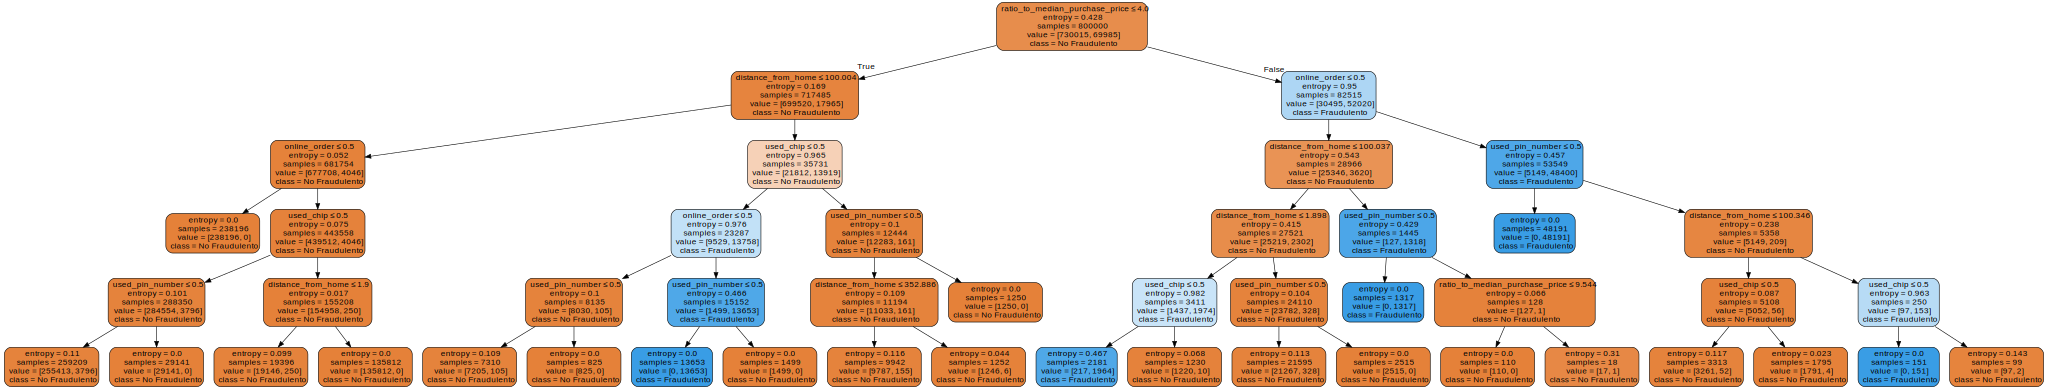

In [112]:
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=list(t_data.columns.values),
                         class_names=["No Fraudulento", "Fraudulento"],
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Predicción de la data con el arbol de decisión sklearn

In [113]:
y_respuesta = clf.predict(w_test)

In [114]:
y_respuesta

array([0., 0., 0., ..., 0., 1., 0.])

In [115]:
import sklearn

acc = sklearn.metrics.accuracy_score(w_true, y_respuesta, normalize=True, sample_weight=None)

In [116]:
print('Accuracy del árbol de decisión: {}%'.format(acc * 100))

Accuracy del árbol de decisión: 99.366%
